### - Fine-tune ResNet, ConvNext and EfficientNet for your augmented dataset for human/robot classification and compare them.
### - Compare the following on a model of your choice: Fine-Tuned model, model as fixed feature extractor, and model with a Combined Approach

# <center>____________________________ Data ____________________________</center>

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import torch
import torch.nn as nn
from tqdm import tqdm;

/home_domuser/s06mtahe/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

As noralization is part of data transformation, we need the means and stds for the three chanels. I'll begin by obtaining these values on the 'training + validation' data as a whole, since no information from test data should leak to the model at any point (totally unseen data). Later on, when I'm evaluating the model on the test set, I will have to use the means and stds obtained over 'training + validation' to perform transforms. Because again, the model should "supposedly" have no information whatsoever of what it will be up against (test data).

In [3]:
# Resize and ToTensor only (no normalization yet)
temp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("dataset/train", transform=temp_transform)
val_set = datasets.ImageFolder("dataset/val", transform=temp_transform)

train_and_val = ConcatDataset([train_set, val_set])

loader = DataLoader(train_and_val, batch_size=32, shuffle=False)

In [4]:
# Get mean and std for the R, G, and B channels
def get_mean_std(loader):
    mean = 0.
    std = 0.
    nb_samples = 0.

    for data, _ in tqdm(loader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)  # flatten H and W
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [5]:
mean, std = get_mean_std(loader)
print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")

100%|██████████| 4/4 [00:06<00:00,  1.67s/it]

Calculated Mean: tensor([0.4704, 0.4458, 0.4169])
Calculated Std: tensor([0.2250, 0.2159, 0.2180])


Now the pre-trainning transformers

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

In [7]:
train_dataset = datasets.ImageFolder('dataset/train', transform=train_transform)
val_dataset   = datasets.ImageFolder('dataset/val', transform=val_transform)
test_dataset  = datasets.ImageFolder('dataset/test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

Now that the data is ready, we can proceed to the Models

# <center>____________________________ Models ____________________________</center>

In [8]:
torch.cuda.is_available()

True

In [9]:
device = torch.device("cuda")

In [10]:
from torch.utils.tensorboard import SummaryWriter

In [11]:
# from torchvision.transforms import v2
# cutmix = v2.CutMix(num_classes=NUM_CLASSES)

In [12]:
# Utility functions defined below are adapted from lecture material by Angel Villar Coralles.

def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    for i, (images, labels) in enumerate(train_loader):
        # images, labels = cutmix(images labels)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, tboard=None, start_epoch=0):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    assert tboard is not None, f"Tensorboard must be provided!"
    
    for epoch in tqdm(range(num_epochs)):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        tboard.add_scalar(f'Accuracy/Valid', accuracy, global_step=epoch+start_epoch)
        tboard.add_scalar(f'Loss/Valid', loss, global_step=epoch+start_epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        tboard.add_scalar(f'Loss/Train', mean_loss, global_step=epoch+start_epoch)

        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc

In [13]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

# Using common default random seed 13
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

### Finetuning **ResNet18**

In [14]:
from torchvision.models import resnet18
set_random_seed()
model = resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [16]:
# replacing classification head with a single linear layer that outputs 2 logits
# It is more streamlined to get the head number of inputs as below
num_logits = model.fc.in_features
# model.fc = nn.Linear(num_logits, 2)
model.fc = nn.Sequential(
    nn.Linear(num_logits, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

model = model.to(device)

In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Decay LR by a factor of 3 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [19]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "Task1_Logs", "ResNet18_Tuned")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [20]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=15, tboard=writer
    )

  7%|▋         | 1/15 [00:08<01:58,  8.49s/it]

Epoch 1/15
    Train loss: 0.44058
    Valid loss: 0.6536
    Accuracy: 71.875%




 40%|████      | 6/15 [00:41<01:00,  6.73s/it]

Epoch 6/15
    Train loss: 0.00769
    Valid loss: 0.00456
    Accuracy: 100.0%




 73%|███████▎  | 11/15 [01:15<00:26,  6.69s/it]

Epoch 11/15
    Train loss: 0.00339
    Valid loss: 0.00604
    Accuracy: 100.0%




100%|██████████| 15/15 [01:41<00:00,  6.78s/it]

Epoch 15/15
    Train loss: 0.00497
    Valid loss: 0.00582
    Accuracy: 100.0%


Training completed


<ipython-input-21-e0510c29302a>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


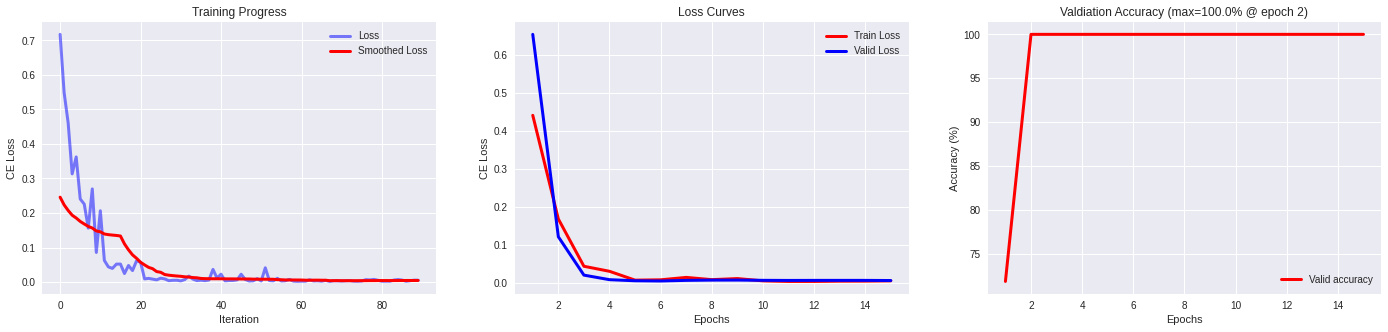

In [21]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

### Finetuning **ConvNext**

In [22]:
from torchvision.models import convnext_tiny
# set_random_seed()
model = convnext_tiny(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
print(model.classifier)

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1000, bias=True)
)


In [24]:
model.classifier[0]

LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)

In [25]:
model.classifier = nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.LayerNorm(768, eps=1e-6),
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)


model = model.to(device)

In [26]:
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96

In [27]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Decay LR by a factor of 3 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [28]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "Task1_Logs", "ConvNext_Tuned")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [29]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=15, tboard=writer
    )

  7%|▋         | 1/15 [00:06<01:34,  6.79s/it]

Epoch 1/15
    Train loss: 0.48383
    Valid loss: 0.6829
    Accuracy: 53.125%




 40%|████      | 6/15 [00:40<01:00,  6.74s/it]

Epoch 6/15
    Train loss: 0.00217
    Valid loss: 0.00264
    Accuracy: 100.0%




 73%|███████▎  | 11/15 [01:14<00:26,  6.73s/it]

Epoch 11/15
    Train loss: 0.00136
    Valid loss: 0.00179
    Accuracy: 100.0%




100%|██████████| 15/15 [01:41<00:00,  6.79s/it]

Epoch 15/15
    Train loss: 0.00134
    Valid loss: 0.00166
    Accuracy: 100.0%


Training completed


<ipython-input-30-e0510c29302a>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


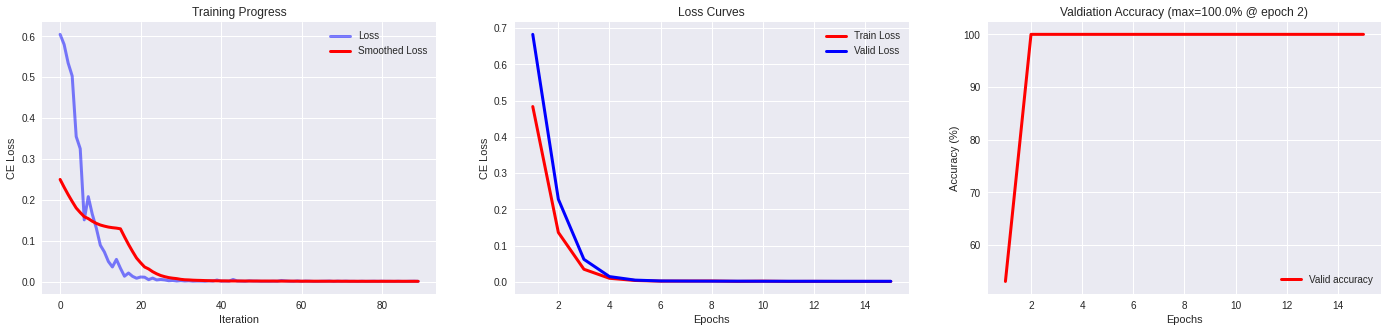

In [30]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

### Finetuning **EfficientNet**

In [31]:
from torchvision.models import efficientnet_b0
# set_random_seed()
model = efficientnet_b0(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
print(model)
# print(model.classifier)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [33]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [34]:
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)


model = model.to(device)

In [35]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [36]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Decay LR by a factor of 3 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [37]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "Task1_Logs", "EfficientNet_Tuned")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [38]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=15, tboard=writer
    )

  7%|▋         | 1/15 [00:06<01:27,  6.23s/it]

Epoch 1/15
    Train loss: 0.65243
    Valid loss: 0.71807
    Accuracy: 43.75%




 40%|████      | 6/15 [00:37<00:55,  6.21s/it]

Epoch 6/15
    Train loss: 0.10253
    Valid loss: 0.08715
    Accuracy: 100.0%




 73%|███████▎  | 11/15 [01:08<00:24,  6.21s/it]

Epoch 11/15
    Train loss: 0.0408
    Valid loss: 0.04348
    Accuracy: 100.0%




100%|██████████| 15/15 [01:33<00:00,  6.21s/it]

Epoch 15/15
    Train loss: 0.04838
    Valid loss: 0.03507
    Accuracy: 100.0%


Training completed


<ipython-input-39-e0510c29302a>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


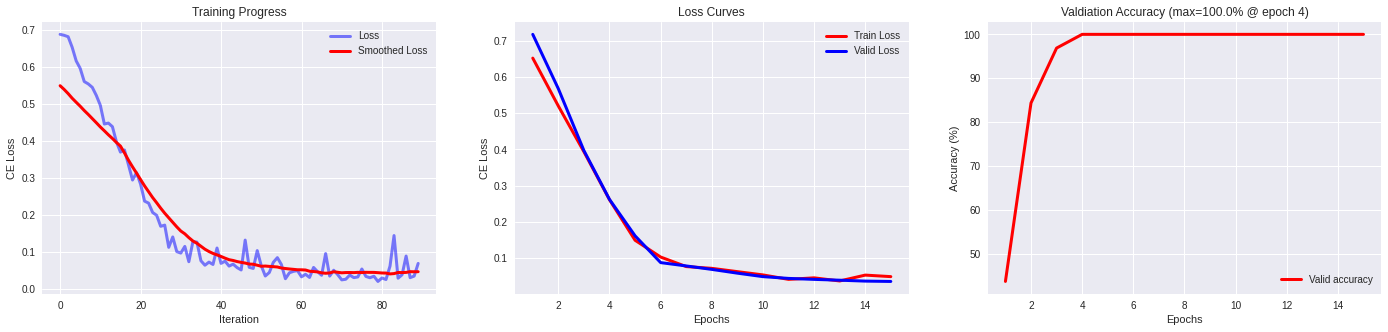

In [39]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

### Conclusion(Short Version): All three models, once fine-tuned, overperformed quite obviously. The reason can be that these models are simply too big for a binary classification task, let alone the fact that they are 1000-fold classifiers. They all reached an accuracy of 100% round about epoch 6. The scale of the task that they are put upon is not big enough to visibly differentiate between the models.

### **ConvNext:** FineTuned vs Fixed Feqture Extractor vs Combined

I picked ConvNext because that **LayerNorm** really piqued my interest. Perhaps this will be an excuse to look further into it.
The results for finetuned ConvNext are aleady depicted earlier. The following, contains experiments on using ConvNext as a fixed feature extractor, as well as combining this approach with full finetuning.

A) Fixed Feature Extractor

In [55]:
from torchvision.models import convnext_tiny
fixedModel = convnext_tiny(pretrained=True)

for param in fixedModel.parameters():
    param.requires_grad = False

# Replace the classifier with a new trainable MLP head
fixedModel.classifier = nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.LayerNorm(768, eps=1e-6),
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)


fixedModel = fixedModel.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
for name, param in fixedModel.named_parameters():
    if param.requires_grad:
        print(name)

classifier.1.weight
classifier.1.bias
classifier.2.weight
classifier.2.bias
classifier.5.weight
classifier.5.bias


In [57]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(fixedModel.parameters(), lr=1e-4)

# Decay LR by a factor of 3 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [59]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "Task1_Logs", "ConvNext_Fixed_Feature_Extractor")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [60]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=fixedModel, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=15, tboard=writer
    )

  7%|▋         | 1/15 [00:06<01:34,  6.71s/it]

Epoch 1/15
    Train loss: 0.61209
    Valid loss: 0.6403
    Accuracy: 75.0%




 40%|████      | 6/15 [00:40<01:00,  6.74s/it]

Epoch 6/15
    Train loss: 0.15715
    Valid loss: 0.16233
    Accuracy: 100.0%




 73%|███████▎  | 11/15 [01:13<00:26,  6.66s/it]

Epoch 11/15
    Train loss: 0.11149
    Valid loss: 0.12205
    Accuracy: 100.0%




100%|██████████| 15/15 [01:40<00:00,  6.69s/it]

Epoch 15/15
    Train loss: 0.08767
    Valid loss: 0.11431
    Accuracy: 100.0%


Training completed


<ipython-input-61-e0510c29302a>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


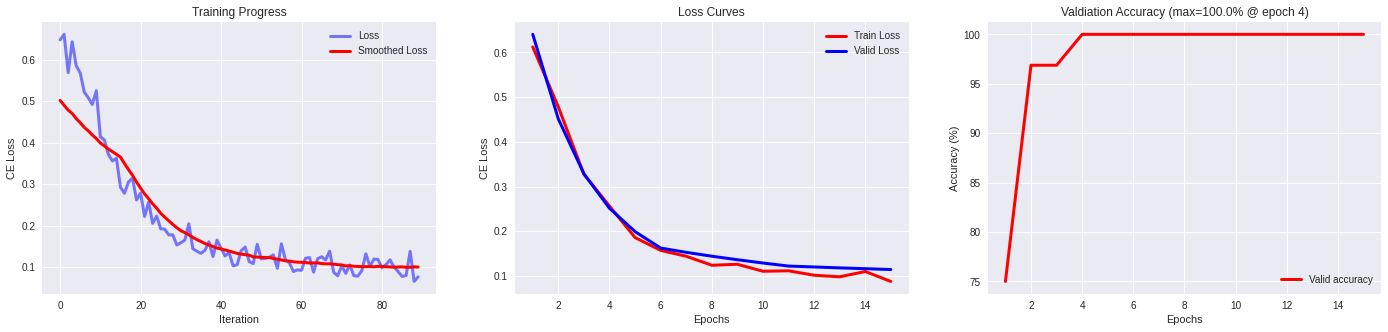

In [61]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

B) Combined Approach

In [45]:
from torchvision.models import convnext_tiny
combinedModel = convnext_tiny(pretrained=True)

for param in combinedModel.parameters():
    param.requires_grad = False

# Replace the classifier with a new trainable MLP head
combinedModel.classifier = nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.LayerNorm(768, eps=1e-6),
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)


combinedModel = combinedModel.to(device)

In [46]:
for name, param in combinedModel.named_parameters():
    if param.requires_grad:
        print(name)

classifier.1.weight
classifier.1.bias
classifier.2.weight
classifier.2.bias
classifier.5.weight
classifier.5.bias


In [47]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(combinedModel.parameters(), lr=1e-4)

# Decay LR by a factor of 3 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [48]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "Task1_Logs", "ConvNext_Combined_Approach")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [49]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=combinedModel, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=15, tboard=writer
    )

  7%|▋         | 1/15 [00:06<01:34,  6.75s/it]

Epoch 1/15
    Train loss: 0.65903
    Valid loss: 0.72241
    Accuracy: 50.0%




 40%|████      | 6/15 [00:40<01:00,  6.69s/it]

Epoch 6/15
    Train loss: 0.17878
    Valid loss: 0.19564
    Accuracy: 96.875%




 73%|███████▎  | 11/15 [01:13<00:26,  6.67s/it]

Epoch 11/15
    Train loss: 0.13795
    Valid loss: 0.15204
    Accuracy: 96.875%




100%|██████████| 15/15 [01:40<00:00,  6.72s/it]

Epoch 15/15
    Train loss: 0.11705
    Valid loss: 0.14327
    Accuracy: 96.875%


Training completed


Now unfreeze the backbone model

In [50]:
for param in combinedModel.parameters():
    param.requires_grad = True

In [51]:
# Lowering learning rate
for g in optimizer.param_groups:
    g['lr'] *= 0.7

In [52]:
next_train_loss, next_val_loss, next_loss_iters, next_valid_acc = train_model(
        model=combinedModel, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=10,  tboard=writer, start_epoch=10
    )

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:07<01:04,  7.22s/it]

Epoch 1/10
    Train loss: 0.12077
    Valid loss: 0.14113
    Accuracy: 96.875%




 60%|██████    | 6/10 [00:43<00:29,  7.26s/it]

Epoch 6/10
    Train loss: 0.08322
    Valid loss: 0.11758
    Accuracy: 96.875%




100%|██████████| 10/10 [01:12<00:00,  7.24s/it]

Epoch 10/10
    Train loss: 0.08037
    Valid loss: 0.11214
    Accuracy: 96.875%


Training completed


In [53]:
concat_train_loss = train_loss + next_train_loss
concat_val_loss = val_loss + next_val_loss
concat_loss_iters = loss_iters + next_loss_iters
concat_valid_acc = valid_acc + next_valid_acc

<ipython-input-54-6746bf4df547>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


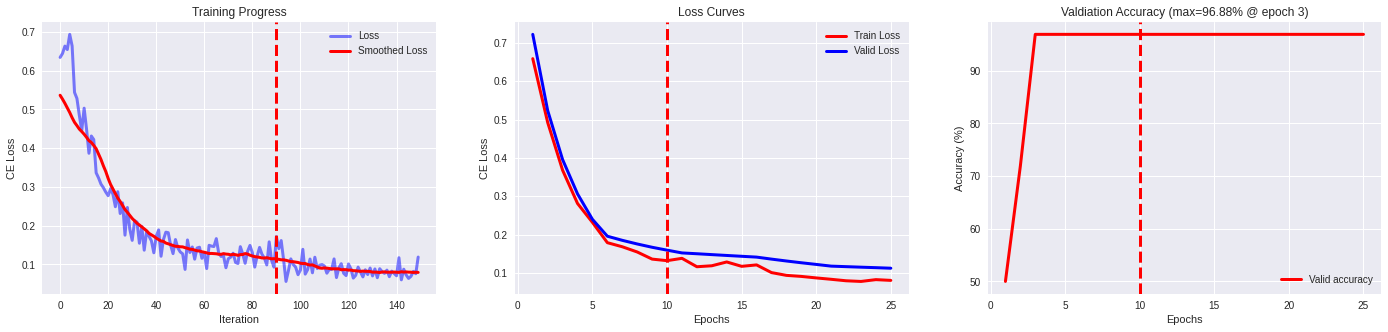

In [54]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(concat_loss_iters, 31)
ax[0].plot(concat_loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")
ax[0].axvline(x=len(loss_iters), color="red", ls="--", linewidth=3)

epochs = np.arange(len(concat_train_loss)) + 1
ax[1].plot(epochs, concat_train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, concat_val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")
ax[1].axvline(x=10, color="red", ls="--", linewidth=3)

epochs = np.arange(len(concat_val_loss)) + 1
ax[2].plot(epochs, concat_valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(concat_valid_acc),2)}% @ epoch {np.argmax(concat_valid_acc)+1})")
ax[2].axvline(x=10, color="red", ls="--", linewidth=3)

plt.show()